## This notebook contains code to create the figures shown in "Hot extremes have become drier in the US Southwest" by Karen A. McKinnon, Andrew Poppick, and Isla R. Simpson


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
import os
import calendar

import statsmodels.api as sm
from scipy.spatial import distance_matrix, Voronoi, voronoi_plot_2d, ConvexHull
from scipy.stats import spearmanr, pearsonr, t
import scipy.special as special
from scipy.signal import detrend

from compound_extremes import utils
from humidity_variability.utils import add_date_columns
from helpful_utilities.general import lowpass_butter

import geopandas
import salem
from shapely.geometry import shape, Point
import geojson

import matplotlib.gridspec as gridspec
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Some helper functions

In [2]:
def sel_season(month, month_start, month_end):
    return (month >= month_start) & (month <= month_end)

In [3]:
def subset_to_west(da, lon_range, lat_range, roi):
    
    """ NEED TO SORT ARRAYS BY ORDERED LAT/LON """
    
    try:
        da = da.sel(latitude=slice(lat_range[0], lat_range[1]),
                    longitude=slice(lon_range[0], lon_range[1]))
    except:
        da = da.sel(lat=slice(lat_range[0], lat_range[1]),
                    lon=slice(lon_range[0], lon_range[1]))
    
    return da.salem.roi(geometry=roi, crs='wgs84')

### Specify parameters and directories, load files

The user will need to update this code block with where they have saved the fitted values from the quantile smoothing splines model.

In [4]:
start_year = 1973  # for ISD1973, or 1950 for ISD1950
end_year = 2019
start_month = 7
end_month = 9
datatype = 'ISD'
predictor_name = 'GMT'  # 'year' or 'GMT'. Published analysis uses GMT.
grouping = 'year'
humidity_var = 'Q'
temp_var = 'TMP'
qs = np.array([0.05, 0.1, 0.5, 0.9, 0.95])
percentile_cutoff = 33  # for ERA5 composites

# This folder contains the ISD station data
datadir = '/glade/work/mckinnon/ISD/csv'

# This folder contains files such as
# ISD_US_extremes_params_trend_GMT_1973_2019_month_7-9_*.npz
# which contains the fitted parameters from the quantile smoothing splines model for each station
paramdir = '/glade/work/mckinnon/ISD/csv/params'

# This folder contains the folders ERA5 and JRA55, which have the parameter fits for those reanalyses
reanalysis_base_dir = '/glade/work/mckinnon'

# This folder is used to save pre-processed files used for the figures
fdir = '/glade/work/mckinnon/dry_west/processed_data'

# and figures will be saved here
figdir = '/glade/u/home/mckinnon/compound_extremes/compound_extremes/figs'

# This folder should contain the sub-daily values from ERA5
daily_ERA_dir = '/glade/work/mckinnon/ERA5/day'

# This folder contains the monthly values from ERA5
era5_dir = '/glade/work/mckinnon/ERA5/month'

# This folder contains the CMIP6 model output
cmip6_dir = '/glade/scratch/mckinnon/cmip6'

# GPCC precipitation (https://psl.noaa.gov/data/gridded/data.gpcc.html)
gpcc_fname = '/glade/work/mckinnon/GPCC/precip.comb.v2018to2016-v6monitorafter.total.nc'

# open metadata
metadata = pd.read_csv('%s/new_metadata.csv' % datadir)
station_id = ['%06d-%05d' % (row['usaf'], row['wban']) for _, row in metadata.iterrows()]
metadata = metadata.assign(station_id=station_id)



### Domain and outline for maps

In [5]:
# for maps
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 21, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# ROI
gjson_fname_west = '../shapefiles/interior_west.json'
interior_west = geopandas.read_file(gjson_fname_west)

lon_range = (np.min(interior_west['geometry'][0].exterior.coords.xy[0]), 
             np.max(interior_west['geometry'][0].exterior.coords.xy[0]))
lat_range = (np.min(interior_west['geometry'][0].exterior.coords.xy[1]), 
             np.max(interior_west['geometry'][0].exterior.coords.xy[1]))

with open(gjson_fname_west) as f:
    geo = geojson.load(f)
    interior_west_shapely = shape(geo[0]['geometry'])

### The block below pulls out the station data in the western US alone, and saves a metadata file to reference lat/lon/station id

In [6]:
station_list = [f.split('_')[-1].split('.')[0] for f in 
                glob('%s/ISD_US_extremes_params_trend_%s_%04d_%04d_month_%i-%i*.npz' 
                     % (paramdir, predictor_name, start_year, end_year, start_month, end_month))]
save_df = '%s/western_data_ISD_%04d_%04d_month_%i-%i.csv' % (fdir, start_year, end_year, start_month, end_month)
save_meta = '%s/western_meta_ISD_%04d_%04d_month_%i-%i.csv' % (fdir, start_year, end_year, start_month, end_month)

if os.path.isfile(save_df):
    western_df = pd.read_csv(save_df)
    western_meta = pd.read_csv(save_meta)                               
else:
    western_df = []
    western_meta = []
    for station in station_list:
        lat = metadata.loc[metadata['station_id']==station, 'lat'].values[0]
        lon = metadata.loc[metadata['station_id']==station, 'lon'].values[0]

        in_west = interior_west.contains(Point(lon, lat))[0]

        if not in_west:
            continue
        print(station)
        df = pd.read_csv('%s/%s.csv' % (datadir, station))

        df = df[~np.isnan(df[humidity_var])]
        df = df[~np.isnan(df[temp_var])]
        
        # Reset index, then get rid of the extra column
        df = df.reset_index()
        df = df.drop(columns=[df.columns[0]])
        
        df = add_date_columns(df)
        # Fit seasonal cycle with first three harmonics and remove
        _, residual_T, _ = utils.fit_seasonal_cycle(df['doy'], df[temp_var].copy(), nbases=3)
        # Dew point seasonal cycle requires 10 harmonics because rapid uptick in monsoon regions
        _, residual_H, _ = utils.fit_seasonal_cycle(df['doy'], df[humidity_var].copy(), nbases=10)

        df = df.assign(**{'%s_anom' % humidity_var: residual_H})
        df = df.assign(**{'%s_anom' % temp_var: residual_T})

        df = df.loc[(df['month'] >= start_month) & (df['month'] <= end_month)]

        # Pull out correct year span
        df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
        df['station_id'] = station
        df['state'] = metadata.loc[metadata['station_id']==station, 'state'].values[0]
        df['lat'] = lat
        df['lon'] = lon

        western_df.append(df)
        western_meta.append(metadata.loc[metadata['station_id']==station])

    western_df = (pd.concat(western_df)).reset_index()
    western_meta = (pd.concat(western_meta)).reset_index()
    western_df.to_csv(save_df)
    western_meta.to_csv(save_meta)
    
# Get rid of extra columns
western_meta = western_meta.loc[:, np.isin(western_meta.columns, western_meta.columns[4:])]
western_df = western_df.loc[:, np.isin(western_df.columns, western_df.columns[2:])]

### The block below unpacks and saves the relevant parameter values from the quantile smoothing splines model

In [7]:
fit_data_ISD = '%s/ISD_US_map_data_trend_%s_%i_%i_month_%i-%i.npz' % (fdir, predictor_name, 
                                                                      start_year, end_year,
                                                                      start_month, end_month)

param_fits = sorted(glob('%s/ISD_US_extremes_params_trend_%s_%i_%i_month_%i-%i*.npz' %
                         (paramdir, predictor_name, start_year, end_year, start_month, end_month)))

temperature_percentiles = np.arange(0.5, 100, 0.5)
nfiles = len(param_fits)

if os.path.isfile(fit_data_ISD):
    ds = np.load(fit_data_ISD)
    lats = ds['lats']
    lons = ds['lons']
    delta_H = ds['delta_H']
    s0_H = ds['s0_H']
    rho = ds['rho']
else:
    
    lats = np.empty((nfiles, ))
    lons = np.empty((nfiles, ))
    delta_H = np.empty((len(temperature_percentiles), len(qs), nfiles))
    s0_H = np.empty((len(temperature_percentiles), len(qs), nfiles))
    rho = np.empty((nfiles, ))

    for ct, f in enumerate(param_fits):
        
        print('%i/%i' % (ct, len(param_fits)))
        ds = np.load(f)

        T = ds['T']
        H = ds['H']
        BETA = ds['BETA']
        G = ds['G']
        n = len(T)
        
        # spearman rank correlation
        rho[ct] = spearmanr(T, H)[0]

        ncols = 2 + 2*n
        X0 = np.ones((n, ncols))
        X0[:, 1] = 0
        X0[:, 2:(2 + n)] = np.identity(n)
        X0[:, (2 + n):] = np.identity(n)*0
        qhat0 = np.dot(X0, BETA)
        
        # find the index closest to each temperature percentile
        idx_sel = [np.argmin(np.abs(T - np.percentile(T, p))) for p in temperature_percentiles]
        
        s0 = qhat0[idx_sel]
        s0_H[..., ct] = s0
        
        del X0, qhat0
        
        X1 = np.ones((n, ncols))
        X1[:, 1] = np.min(G)
        X1[:, 2:(2 + n)] = np.identity(n)
        X1[:, (2 + n):] = np.identity(n)*np.min(G)
        qhat1 = np.dot(X1, BETA)

        X2 = np.ones((n, ncols))
        X2[:, 1] = np.max(G)
        X2[:, 2:(2 + n)] = np.identity(n)
        X2[:, (2 + n):] = np.identity(n)*np.max(G)
        qhat2 = np.dot(X2, BETA)

        delta = qhat2[idx_sel] - qhat1[idx_sel]
        
        del T, H, BETA, G, X1, X2, qhat1, qhat2, idx_sel

        lats[ct] = ds['lat']
        lons[ct] = ds['lon']
        delta_H[..., ct] = delta
        
        del delta

    np.savez(fit_data_ISD, lats=lats, lons=lons, delta_H=delta_H, 
             temperature_percentiles=temperature_percentiles, 
             qs=qs, s0_H=s0_H, rho=rho)

### Calculate area represented by each station

In [8]:
if start_year == 1973:
    # load locations for all stations in CONUS to do tesselation 
    station_ds = np.load(fit_data_ISD)
    all_station_lat = station_ds['lats']
    all_station_lon = station_ds['lons']
    all_station_lat = np.round(all_station_lat, decimals=3)
    all_station_lon = np.round(all_station_lon, decimals=3)

    def voronoi_volumes(points):
        v = Voronoi(points)
        vol = np.zeros(v.npoints)
        for i, reg_num in enumerate(v.point_region):
            indices = v.regions[reg_num]
            if -1 in indices: # some regions can be opened
                vol[i] = np.inf
            else:
                vol[i] = ConvexHull(v.vertices[indices]).volume
        return vol

    vol = voronoi_volumes(np.vstack((all_station_lon, all_station_lat)).T)

    # Add Voronoi volumes to metadata
    area_weights = np.nan*np.ones(len(western_meta))
    for ct, row in western_meta.iterrows():
        # find matching lat index
        this_lat = np.round(row['lat'], decimals=3)
        this_lon = np.round(row['lon'], decimals=3)
        match_idx = (all_station_lat == this_lat) & (all_station_lon == this_lon)
        area_weights[ct] = vol[match_idx]

    # in both cases, one outlier, set to max
    sorted_vals = np.sort(area_weights)
    area_weights[np.argmax(area_weights)] = sorted_vals[-2]

    western_meta = western_meta.assign(area_weights=area_weights)
    
# Story basically the same regardless of how this weighting is done (squared or not, etc)
if start_year == 1950:
    d = distance_matrix(np.vstack((western_meta.lon, western_meta.lat)).T, 
                        np.vstack((western_meta.lon, western_meta.lat)).T)

    # for each station, weight by (0.5d1 + 0.5d2)**2
    # approximating circle where radius is average of two closest stations
    d[d==0] = np.nan
    weights = np.array([((np.sort(d[ct, :])[:1])) for ct in range(len(western_meta))])

    western_meta = western_meta.assign(area_weights=weights)

### Calculate and load amplification indices for each dataset

Note that the below code block requires you to have run the QSS model on ISD1973, ISD1950, ERA5, and JRA-55

In [9]:
# Hot extremes between 85-95 percentile, dry extremes below 10 percentile with below args
T0 = 90
half_width = 5
qperc = 0.1
grouping = 'year'

params = {'T0': T0,
          'half_width': half_width,
          'fit_data': fit_data_ISD,
          'qperc' : qperc,
          'grouping': grouping}

#### Calculate reanalysis amplification indices

In [10]:
for reanalysis_name in list(('JRA55', 'ERA5')):
    if reanalysis_name == 'JRA55':
        start_year_reanalysis = 1958
        end_year_reanalysis = 2019
    elif reanalysis_name == 'ERA5':
        start_year_reanalysis = 1979
        end_year_reanalysis = 2019

    savename = '%s/%s_amplification_%s_%i_%i_month_%i-%i.npz' % (fdir, reanalysis_name, grouping, 
                                                                 start_year_reanalysis, end_year_reanalysis,
                                                                 start_month, end_month)
    
    if os.path.isfile(savename):
        if reanalysis_name == 'JRA55':
            amplification_JRA55 = np.load(savename)['amplification']
        elif reanalysis_name == 'ERA5':
            amplification_ERA5 = np.load(savename)['amplification']
    else:
        fit_data = '%s/%s_US_map_data_trend_%s_%i_%i_month_%i-%i.npz' % (fdir, reanalysis_name, 
                                                                         predictor_name, 
                                                                         start_year_reanalysis, 
                                                                         end_year_reanalysis,
                                                                         start_month, end_month)

        param_fits = sorted(glob('%s/%s/csv/params/%s*%i_%i_month_%i-%i*.npz'
                                 % (reanalysis_base_dir, reanalysis_name, 
                                    reanalysis_name, start_year_reanalysis, end_year_reanalysis,
                                    start_month, end_month)))

        temperature_percentiles = np.arange(0.5, 100, 0.5)
        nfiles = len(param_fits)

        if os.path.isfile(fit_data):
            ds = np.load(fit_data)
            lats = ds['lats']
            lons = ds['lons']
            delta_H = ds['delta_H']
            s0_H = ds['s0_H']
        else:

            lats = np.empty((nfiles, ))
            lons = np.empty((nfiles, ))
            delta_H = np.empty((len(temperature_percentiles), len(qs), nfiles))
            s0_H = np.empty((len(temperature_percentiles), len(qs), nfiles))

            for ct, f in enumerate(param_fits):
                if ct % 20 == 0:
                    print('%i/%i' % (ct, len(param_fits)))
                ds = np.load(f)

                T = ds['T']
                H = ds['H']
                BETA = ds['BETA']
                G = ds['G']
                n = len(T)

                ncols = 2 + 2*n
                X0 = np.ones((n, ncols))
                X0[:, 1] = 0
                X0[:, 2:(2 + n)] = np.identity(n)
                X0[:, (2 + n):] = np.identity(n)*0
                qhat0 = np.dot(X0, BETA)

                # find the index closest to each temperature percentile
                idx_sel = [np.argmin(np.abs(T - np.percentile(T, p))) for p in temperature_percentiles]

                s0 = qhat0[idx_sel]
                s0_H[..., ct] = s0

                del X0, qhat0

                X1 = np.ones((n, ncols))
                X1[:, 1] = np.min(G)
                X1[:, 2:(2 + n)] = np.identity(n)
                X1[:, (2 + n):] = np.identity(n)*np.min(G)
                qhat1 = np.dot(X1, BETA)

                X2 = np.ones((n, ncols))
                X2[:, 1] = np.max(G)
                X2[:, 2:(2 + n)] = np.identity(n)
                X2[:, (2 + n):] = np.identity(n)*np.max(G)
                qhat2 = np.dot(X2, BETA)

                delta = qhat2[idx_sel] - qhat1[idx_sel]

                del T, H, BETA, G, X1, X2, qhat1, qhat2, idx_sel

                lats[ct] = ds['lat']
                lons[ct] = ds['lon']
                delta_H[..., ct] = delta

                del delta

            np.savez(fit_data, lats=lats, lons=lons, delta_H=delta_H, 
                     temperature_percentiles=temperature_percentiles, 
                     qs=qs, s0_H=s0_H)

        re_meta = pd.read_csv('%s/%s/csv/new_metadata.csv' % (reanalysis_base_dir, reanalysis_name))
        re_meta = re_meta.assign(area_weights=np.cos(np.deg2rad(re_meta['lat'])))

        # create df that has anomalies and station_id
        re_fnames = sorted(glob('%s/%s/csv/*-*.csv' % (reanalysis_base_dir, reanalysis_name)))  
        station_list = [f.split('/')[-1].split('.csv')[0] for f in re_fnames]

        re_datadir = '%s/%s/csv' % (reanalysis_base_dir, reanalysis_name)
        save_df = '%s/western_data_%s_%i_%i_month_%i-%i.csv' % (fdir, reanalysis_name,
                                                                start_year_reanalysis, end_year_reanalysis,
                                                                start_month, end_month)
        if os.path.isfile(save_df):
            re_df = pd.read_csv(save_df)
        else:
            re_df = []
            for ct, station in enumerate(station_list):
                if ct % 20 == 0:
                    print('%i/%i' % (ct, len(station_list)))

                df = pd.read_csv('%s/%s.csv' % (re_datadir, station))
                df = add_date_columns(df)
                
                _, residual_T, _ = utils.fit_seasonal_cycle(df['doy'], df[temp_var].copy(), nbases=3)
                # Humidity seasonal cycle requires 10 harmonics because rapid uptick in monsoon regions
                _, residual_H, _ = utils.fit_seasonal_cycle(df['doy'], df[humidity_var].copy(), nbases=10)

                df = df.assign(**{'%s_anom' % humidity_var: residual_H})
                df = df.assign(**{'%s_anom' % temp_var: residual_T})
                
                df = df.loc[(df['month'] >= start_month) & (df['month'] <= end_month)]

                df['station_id'] = station

                re_df.append(df)

            re_df = (pd.concat(re_df)).reset_index()
            re_df.to_csv(save_df)

        # Drop extra columns
        re_df = re_df.drop(columns=re_df.columns[:2])

        # Add lat, lon to df
        re_df = re_df.assign(lat=np.array([float(s[:5]) for s in re_df['station_id']]))
        re_df = re_df.assign(lon=np.array([float(s[5:]) for s in re_df['station_id']]))

        amplification_re = utils.calculate_amplification_index2(re_df.copy(), re_meta.copy(),
                                                                T0, half_width, grouping, 
                                                                fit_data, qs, qperc)


        params = {'T0': T0,
                  'half_width': half_width,
                  'fit_data': fit_data,
                  'qperc' : qperc,
                  'grouping': grouping}
        np.savez(savename,
                 amplification=amplification_re,
                 params=params)

#### Calculate ISD amplification indices

In [11]:
savename = '%s/ISD_amplification_%s_%i_%i_month_%i-%i.npz' % (fdir, grouping, 
                                                              start_year, end_year,
                                                              start_month, end_month)

if not os.path.isfile(savename):
    amplification = utils.calculate_amplification_index2(western_df.copy(), western_meta.copy(),
                                                         T0, half_width, grouping, 
                                                         fit_data_ISD, qs, qperc)

    np.savez(savename,
             amplification=amplification,
             params=params)
    
    if start_year == 1950:
        amplification_1950 = amplification.copy()
    elif start_year == 1973:
        amplification_1973 = amplification.copy()

#### Load all amplification indices

In [12]:
# Load all amplification indices
for data_name in list(('ISD_1973', 'ISD_1950', 'JRA55', 'ERA5')):
    if data_name == 'JRA55':
        this_start_year = 1958
    elif data_name == 'ERA5':
        this_start_year = 1979
    else:
        this_start_year = int(data_name[4:])

    savename = '%s/%s_amplification_%s_%i_%i_month_%i-%i.npz' % (fdir, data_name.split('_')[0], grouping, 
                                                                 this_start_year, end_year,
                                                                 start_month, end_month)
    all_years = np.arange(1950, 2020)
    nmissing = this_start_year - 1950
    nan_pad = np.nan*np.ones((nmissing, ))
    if data_name == 'JRA55':
        amplification_JRA55 = np.load(savename)['amplification']
        
        amplification_JRA55 = pd.DataFrame({'year': all_years, 
                                            'JRA55': np.hstack((nan_pad, amplification_JRA55))})
        amplification_JRA55 = amplification_JRA55.set_index('year')
    elif data_name == 'ERA5':
        amplification_ERA5 = np.load(savename)['amplification']
        amplification_ERA5 = pd.DataFrame({'year': all_years, 
                                           'ERA5': np.hstack((nan_pad, amplification_ERA5))})
        amplification_ERA5 = amplification_ERA5.set_index('year')
    elif data_name == 'ISD_1973':
        amplification_ISD1973 = np.load(savename)['amplification']
        amplification_ISD1973 = pd.DataFrame({'year': all_years, 
                                              'ISD1973': np.hstack((nan_pad, amplification_ISD1973))})
        amplification_ISD1973 = amplification_ISD1973.set_index('year')
    elif data_name == 'ISD_1950':
        amplification_ISD1950 = np.load(savename)['amplification']
        amplification_ISD1950 = pd.DataFrame({'year': all_years, 
                                              'ISD1950': amplification_ISD1950})
        amplification_ISD1950 = amplification_ISD1950.set_index('year')

amplification_all = pd.concat([amplification_ERA5, amplification_ISD1950, 
                               amplification_ISD1973, amplification_JRA55], 
                              axis=1)

amplification_avg = amplification_all.mean(axis=1)

In [13]:
# Calculate correlation between all of the amplification indices
print('ISD 1950 - ISD 1973: %0.2f' 
      % amplification_ISD1950.corrwith(amplification_ISD1973['ISD1973'])[0])
print('ISD 1950 - ERA5: %0.2f' 
      % amplification_ISD1950.corrwith(amplification_ERA5['ERA5'])[0])
print('ISD 1973 - ERA5: %0.2f' 
      % amplification_ISD1973.corrwith(amplification_ERA5['ERA5'])[0])
print('JRA55 - ERA5: %0.2f' 
      % amplification_JRA55.corrwith(amplification_ERA5['ERA5'])[0])
print('JRA55 - ISD 1950: %0.2f' 
      % amplification_JRA55.corrwith(amplification_ISD1950['ISD1950'])[0])
print('JRA55 - ISD 1973: %0.2f' 
      % amplification_JRA55.corrwith(amplification_ISD1973['ISD1973'])[0])

ISD 1950 - ISD 1973: 0.82
ISD 1950 - ERA5: 0.75
ISD 1973 - ERA5: 0.89
JRA55 - ERA5: 0.92
JRA55 - ISD 1950: 0.75
JRA55 - ISD 1973: 0.88


### Load time series of relevant modes and GMTA

In [14]:
# Load annual mean GMT and AMV, and low-pass filter
lowpass_freq = 1/10

## Get GMTA (via http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt)
GMT_fname = '../data/Land_and_Ocean_complete.txt'
gmt_data = pd.read_csv(GMT_fname, comment='%', header=None, delim_whitespace=True).loc[:, :2]
gmt_data.columns = ['year', 'month', 'GMTA']

# drop the second half, which infers sea ice T from water temperature
stop_idx = np.where(gmt_data['year'] == gmt_data['year'][0])[0][12] - 1
gmt_data = gmt_data.loc[:stop_idx, :]

# remove last year (not complete)
gmt_data = gmt_data[gmt_data['year'] < np.max(gmt_data['year'])]

# Perform lowpass filtering
gmt_smooth = lowpass_butter(12, lowpass_freq, 3, gmt_data['GMTA'].values)
gmt = gmt_data.assign(GMTA=gmt_smooth)

# take annual average
gmt = gmt.groupby('year').mean()
gmt = gmt.drop(columns=['month'])

# Pull out range of GMTA over the primary period of analysis
gmt_short = gmt[(gmt.index >= 1973) & (gmt.index <= 2019)]
gmt_short = gmt_short - np.mean(gmt_short)
G_range = np.max(gmt_short.values) - np.min(gmt_short.values)

## Get AMV, calculated with CVDP on ERSSTv5 data
amv_file = '../data/amo_monthly_ERSSTv5_1854_2020.nc'
da_amv = xr.open_dataarray(amv_file)
amo = da_amv.mean('mon')
amo = amo.sel(year=slice(1854, 2019))
amo = amo.assign_coords(year=amo.year.astype(int))
amo_10yr = lowpass_butter(1, lowpass_freq, 3, amo.values)
amo.values = amo_10yr
amo = amo.to_dataframe()

## Get PDO (via )
pdo_file = '../data/pdo_ncei.csv'
pdo = pd.read_csv(pdo_file, header=1)
# change date to get year and month
pdo_year = np.array([int((str(d))[:4]) for d in pdo['Date']])
pdo_month = np.array([int((str(d))[4:]) for d in pdo['Date']])
pdo = pdo.assign(year=pdo_year)
pdo = pdo.assign(month=pdo_month)
pdo = pdo.groupby('year').mean()['Value']

## Get ENSO (via https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt)
enso_file = '../data/enso_ncei.txt'
enso = pd.read_csv(enso_file, delim_whitespace=True)
enso = enso.rename(columns={'YR': 'year'})
enso = enso.set_index('year')
enso = enso[enso['SEAS']=='DJF']['ANOM']

## Figure 1:  Changes in the distribution of specific humidity as a function of increasing global mean temperature anomalies (GMTA) and local temperature.

In [15]:
idx5 = np.where(qs==0.05)[0][0]
idx10 = np.where(qs==0.1)[0][0]
idx50 = np.where(qs==0.50)[0][0]
idx90 = np.where(qs==0.90)[0][0]
idx95 = np.where(qs==0.95)[0][0]

12    PERRY STOKES AIRPORT
Name: station name, dtype: object
1    FRESNO YOSEMITE INTERNATIONAL AIRPORT
Name: station name, dtype: object


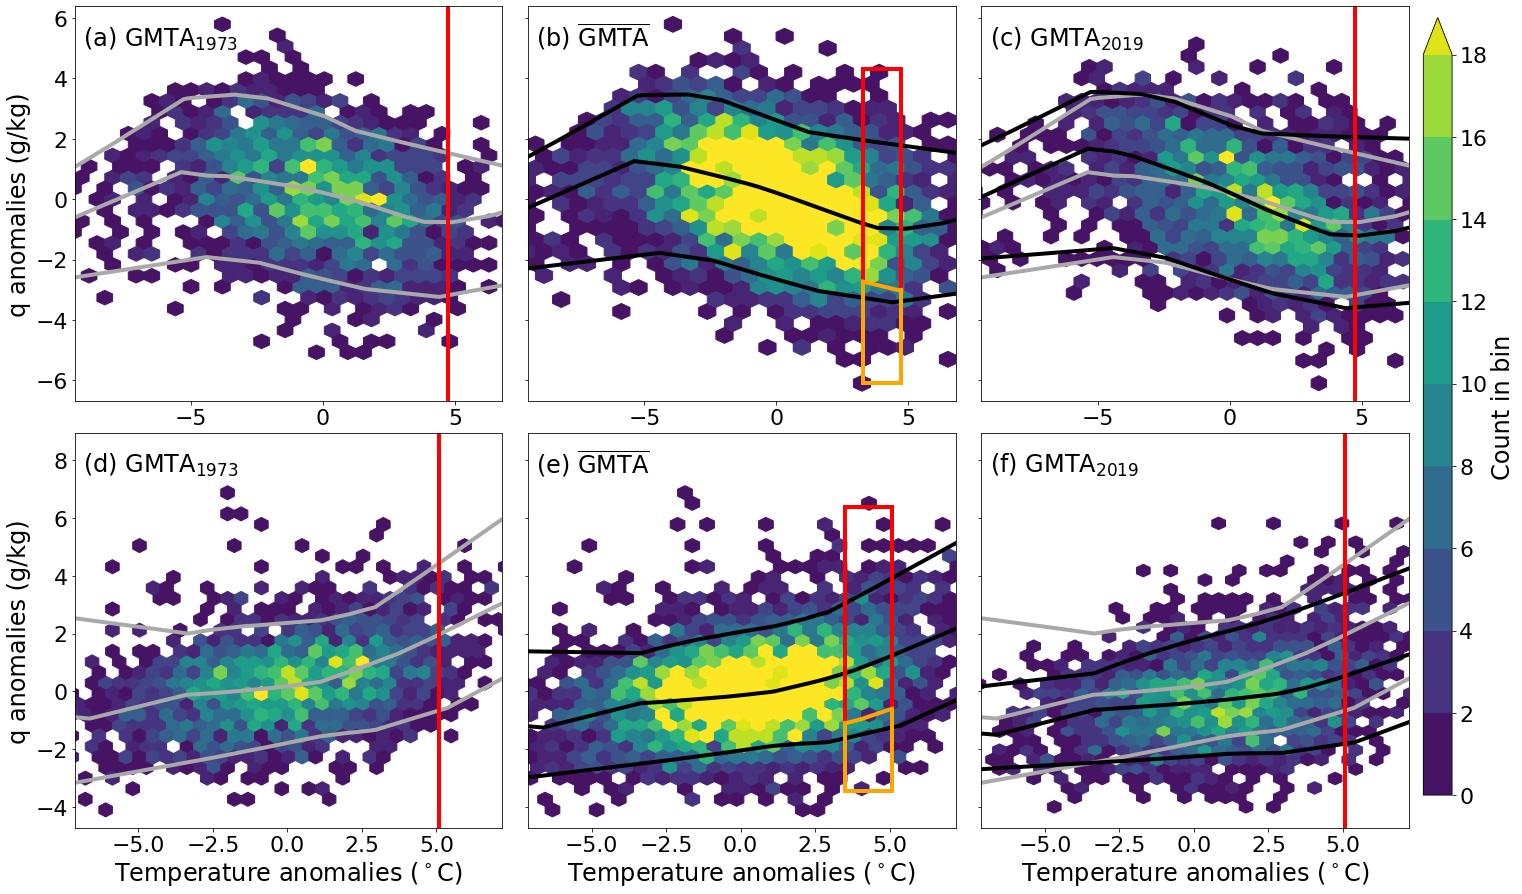

In [16]:
stations_plot = ['724645-23070', '723890-93193']

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 12), sharex='row', sharey='row')
fig.tight_layout()
lw = 4
letters = np.array([['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)']])
bins = np.arange(0, 21, 2)
for ct, station_use in enumerate(stations_plot):  #western_stations['station_id']:
    
    print(western_meta.loc[western_meta['station_id']==station_use, 'station name'])
    
    # Load fitted quantiles and original data
    f = sorted(glob('%s/ISD_US_extremes_params_trend_%s_%i_%i_month_%i-%i_%s.npz' 
                    % (paramdir, predictor_name, start_year, end_year, start_month, end_month, station_use)))[0]
    ds = np.load(f)

    T = ds['T']
    H = ds['H']
    BETA = ds['BETA']
    G = ds['G']
    n = len(T)

    # Get fit with GMTA = 0
    ncols = 2 + 2*n
    X0 = np.ones((n, ncols))
    X0[:, 1] = 0
    X0[:, 2:(2 + n)] = np.identity(n)
    X0[:, (2 + n):] = np.identity(n)*0
    qhat0 = np.dot(X0, BETA)

    # Get fit with GMTA = 25th percentile
    ncols = 2 + 2*n
    X1 = np.ones((n, ncols))
    X1[:, 1] = np.percentile(G, 25)
    X1[:, 2:(2 + n)] = np.identity(n)
    X1[:, (2 + n):] = np.identity(n)*np.min(G)
    qhat1 = np.dot(X1, BETA)

    # Get fit with GMTA = 75th percentile
    ncols = 2 + 2*n
    X2 = np.ones((n, ncols))
    X2[:, 1] = np.percentile(G, 75)
    X2[:, 2:(2 + n)] = np.identity(n)
    X2[:, (2 + n):] = np.identity(n)*np.max(G)
    qhat2 = np.dot(X2, BETA)

    temperature_percentiles = np.arange(0, 100.1, 0.5)
    idx_sel = np.array([np.argmin(np.abs(T - np.percentile(T, p))) for p in temperature_percentiles])

    T_q0 = 90
    T_qrange = 5
    lowT = T_q0 - T_qrange
    highT = T_q0 + T_qrange

    idx_low = idx_sel[temperature_percentiles==lowT][0]
    idx0 = idx_sel[temperature_percentiles==T_q0][0]
    idx_high = idx_sel[temperature_percentiles==highT][0]
    
    idxT95 = idx_sel[temperature_percentiles==95][0]
    idxT01 = idx_sel[temperature_percentiles==0.5][0]
    idxT99 = idx_sel[temperature_percentiles==99.5][0]
    
    q_hot = H[(T >= np.percentile(T, lowT)) & (T <= np.percentile(T, highT))]

    qsort = np.sort(q_hot)
    q_cut0 = qsort[0]
    q_cut2 = qsort[-1]
    
    ax[ct, 0].set_xlim(T[idxT01], T[idxT99])

    ax[ct, 0].hexbin(T[G < np.median(G)], H[G < np.median(G)], gridsize=(40, 15), 
                     cmap=plt.cm.viridis, mincnt=1, vmin=bins[0], vmax=bins[-1])
    ax[ct, 0].plot(T, qhat1[:, idx5], color='darkgray', lw=lw)
    ax[ct, 0].plot(T, qhat1[:, idx50], color='darkgray', lw=lw)
    ax[ct, 0].plot(T, qhat1[:, idx95], color='darkgray', lw=lw)
    ax[ct, 0].axvline(T[idxT95], color='red', lw=lw)
    ax[ct, 0].text(0.02, 0.90, r'%s GMTA$_{1973}$' % letters[ct, 0], transform=ax[ct, 0].transAxes, fontsize=24)

    ax[ct, 2].hexbin(T[G > np.median(G)], H[G > np.median(G)], gridsize=(40, 15), 
                     cmap=plt.cm.viridis, mincnt=1, vmin=bins[0], vmax=bins[-1])
    ax[ct, 2].plot(T, qhat1[:, idx5], color='darkgray', lw=lw)
    ax[ct, 2].plot(T, qhat1[:, idx50], color='darkgray', lw=lw)
    ax[ct, 2].plot(T, qhat1[:, idx95], color='darkgray', lw=lw)
    ax[ct, 2].plot(T, qhat2[:, idx5], color='black', lw=lw)
    ax[ct, 2].plot(T, qhat2[:, idx50], color='black', lw=lw)
    ax[ct, 2].plot(T, qhat2[:, idx95], color='black', lw=lw)
    ax[ct, 2].axvline(T[idxT95], color='red', lw=lw)
    ax[ct, 2].text(0.02, 0.90, r'%s GMTA$_{2019}$' % letters[ct, 2], 
                   transform=ax[ct, 2].transAxes, fontsize=24)

    im = ax[ct, 1].hexbin(T, H, gridsize=(40, 15), cmap=plt.cm.viridis, mincnt=1, vmin=bins[0], vmax=bins[-1])
    ax[ct, 1].plot(T, qhat0[:, idx5], color='black', lw=lw)
    ax[ct, 1].plot(T, qhat0[:, idx50], color='black', lw=lw)
    ax[ct, 1].plot(T, qhat0[:, idx95], color='black', lw=lw)

    ax[ct, 1].plot([T[idx_low], T[idx_high]], [q_cut0, q_cut0], color='red', lw=lw)
    ax[ct, 1].plot([T[idx_low], T[idx_high]], [q_cut2, q_cut2], color='red', lw=lw)
    ax[ct, 1].plot([T[idx_low], T[idx_low]], [q_cut0, q_cut2], color='red', lw=lw)
    ax[ct, 1].plot([T[idx_high], T[idx_high]], [q_cut0, q_cut2], color='red', lw=lw)

    ax[ct, 1].plot([T[idx_low], T[idx_high]], [q_cut0, q_cut0], color='orange', lw=lw)
    ax[ct, 1].plot([T[idx_low], T[idx_low]], [q_cut0, qhat0[idx_low, idx10]], color='orange', lw=lw)
    ax[ct, 1].plot(T[idx_low:idx_high], qhat0[idx_low:idx_high, idx10], color='orange', lw=lw)
    ax[ct, 1].plot([T[idx_high], T[idx_high]], [q_cut0, qhat0[idx_high, idx10]], color='orange', lw=lw)
    ax[ct, 1].text(0.02, 0.90, r'%s $\overline{\mathrm{GMTA}}$'  % letters[ct, 1], 
                   transform=ax[ct, 1].transAxes, fontsize=24)
    
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.07, 0.02, 0.9])
cb = fig.colorbar(im, cax=cbar_ax, boundaries=bins, extend='max')
cb.set_label('Count in bin', fontsize=24)
cbar_ax.tick_params(labelsize=22)

for a in ax.flatten():
    a.tick_params(labelsize=22)
for a in ax[1, :]:
    a.set_xlabel(r'Temperature anomalies ($^\circ$C)', fontsize=24)
ax[0, 0].set_ylabel(r'q anomalies (g/kg)', fontsize=24)
ax[1, 0].set_ylabel(r'q anomalies (g/kg)', fontsize=24)

plt.savefig('%s/fig01.pdf' % figdir, bbox_inches='tight')

## Figure 2: Decreases in specific humidity in the American Southwest are amplified on hot days.


In [17]:
# Load file with model parameters
temperature_percentiles = np.arange(0.5, 100, 0.5)

ds = np.load(fit_data_ISD)
lats = ds['lats']
lons = ds['lons']
delta_H = ds['delta_H']
s0_H = ds['s0_H']
rho = ds['rho']

In [18]:
# Get summer 5th percentile q from ERA
savename = '%s/ERA_05percentile_q_month_%i-%i.nc' % (fdir, start_month, end_month)

if not os.path.isfile(savename):
    
    f_Td = '%s/Td/ERA5_Td_summer_US.nc' % daily_ERA_dir
    f_p = '%s/p/ERA5_p_summer_US.nc' % daily_ERA_dir

    da_Td = xr.open_dataarray(f_Td)  # K
    da_p = xr.open_dataarray(f_p)  # Pa

    # Calculate q
    e = 6.112*np.exp((17.67*(da_Td - 273.15))/((da_Td - 273.15) + 243.5))
    da_q =  1000*(0.622 * e)/((da_p/100) - (0.378 * e))  # g/kg
    
    da_q = da_q.sel(time=(da_q['time.month'] >= start_month) & (da_q['time.month'] <= end_month))

    # Calculate average over all time
    q_05 = da_q.quantile(q=0.05, dim='time')

    q_05.to_netcdf(savename)
    
else:
    q_05 = xr.open_dataarray(savename)

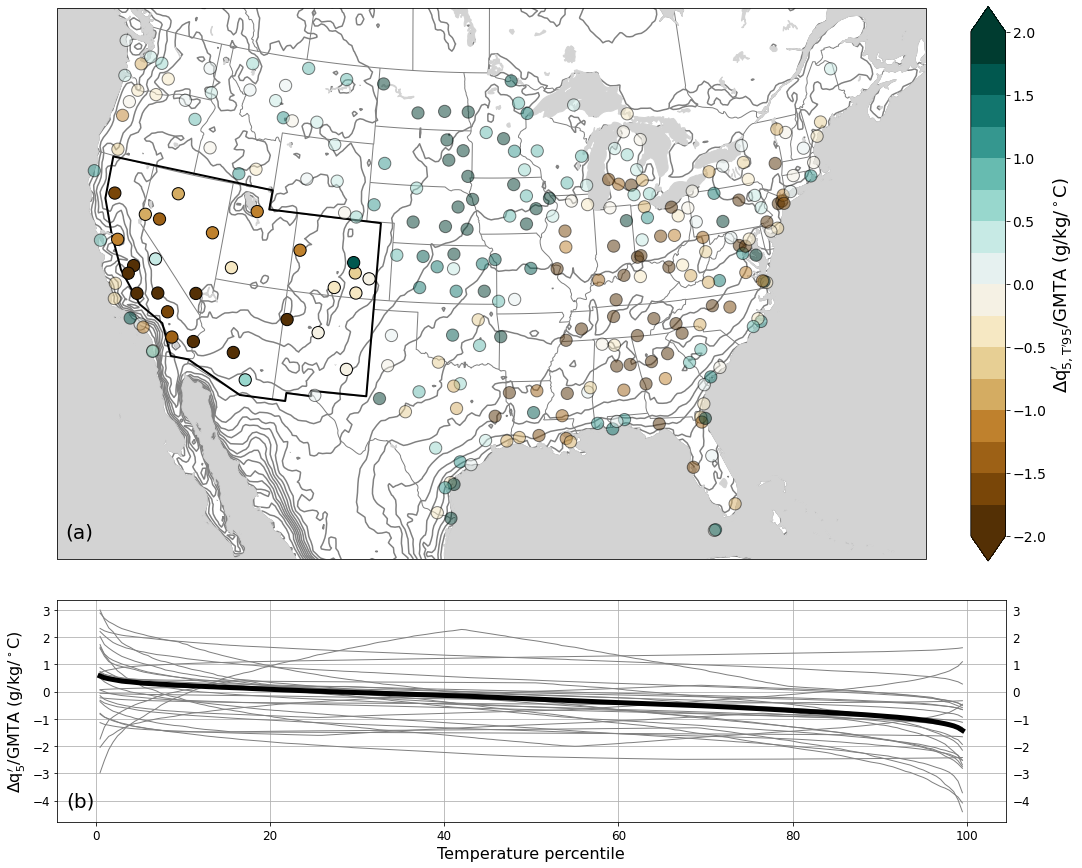

In [19]:
this_q = 0.05
this_T = 95

# trend per 1 deg GMTA
to_plot = (1/G_range)*(delta_H[temperature_percentiles==this_T, qs==this_q, :].squeeze())

fig = plt.figure(figsize=(17, 15))
widths = [10, 0.4]
heights = [2.5, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, 
                        width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.1)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.AlbersEqualArea(central_lon, central_lat)

# Add the map and set the extent
ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
ax_map.set_extent(extent)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax_map.add_feature(cfeature.LAKES, color='lightgray')
ax_map.add_feature(cfeature.LAND, color='white')
ax_map.add_feature(cfeature.OCEAN, color='lightgray', zorder=2)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=0)
ax_map.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=0)
ax_map.add_feature(states_provinces, edgecolor='gray', zorder=0)
ax_map.add_geometries(interior_west['geometry'], crs=ccrs.PlateCarree(), 
                      facecolor='none', edgecolor='black', linewidth=2)

cmap = plt.cm.BrBG
bounds = np.arange(-2, 2.1, 0.25)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Pull out Western stations only
in_west = np.array([interior_west_shapely.contains(Point(this_lon, this_lat)) 
           for (this_lat, this_lon) in zip(lats, lons)])

sc = ax_map.scatter(lons[in_west],
                lats[in_west],
                c=to_plot[in_west],
                transform=ccrs.PlateCarree(),
                s=150,
                cmap=cmap,
                norm=norm,
                alpha=1,
                zorder=3,
                edgecolor='k')

ax_map.scatter(lons[~in_west],
                lats[~in_west],
                c=to_plot[~in_west],
                transform=ccrs.PlateCarree(),
                s=150,
                cmap=cmap,
                norm=norm,
                alpha=0.5,
                zorder=3,
                edgecolor='k')

line_c = q_05.plot.contour(ax=ax_map, transform=ccrs.PlateCarree(), colors='gray',
                           levels=[i for i in np.arange(3, 20, 1) if i != 0], zorder=1)

ax_map.set_title('')
ax_map.text(0.01, 0.04, '(a)', transform=ax_map.transAxes, fontsize=20)

cax = fig.add_subplot(spec[0, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 

cb.set_label(r'$\Delta$q$^\prime_\mathrm{%d, T^\prime%d}$/GMTA (g/kg/$^\circ$C)' % (int(100*this_q), this_T),
             fontsize=18)
ax_ts = fig.add_subplot(spec[1, :])
ax_ts.text(0.01, 0.07, '(b)', transform=ax_ts.transAxes, fontsize=20)

lon_west = np.round(lons[in_west], 3)
lat_west = np.round(lats[in_west], 3)
western_meta = western_meta.assign(lat=np.round(western_meta.lat, 3))
western_meta = western_meta.assign(lon=np.round(western_meta.lon, 3))
weights = np.empty((len(lon_west), ))
for kk in range(len(lon_west)):
    idx = np.where((western_meta.lat == lat_west[kk]) & (western_meta.lon == lon_west[kk]))[0][0]
    weights[kk] = western_meta.loc[idx, 'area_weights']

all_vals = 1/G_range*delta_H[:, qs==this_q, in_west].squeeze()
all_vals_avg = np.sum(all_vals*weights[np.newaxis, :], axis=-1)/np.sum(weights)

ax_ts.plot(temperature_percentiles, all_vals, lw=1, c='gray')
ax_ts.plot(temperature_percentiles, all_vals_avg, '-k', lw=5)
ax_ts.tick_params(labelsize=12)
ax_ts.set_xlabel('Temperature percentile', fontsize=16)
ax_ts.set_ylabel(r'$\Delta$q$^\prime_{%d}$/GMTA (g/kg/$^\circ$C)' % int(100*this_q), fontsize=16)
ax_ts.grid()

ax_ts.tick_params(labelright=True)


plt.savefig('%s/fig02.pdf' % figdir, bbox_inches='tight')

In [20]:
# Calculate average across all western stations of q05_T95
lon_west = np.round(lons[in_west], 3)
lat_west = np.round(lats[in_west], 3)
western_meta = western_meta.assign(lat=np.round(western_meta.lat, 3))
western_meta = western_meta.assign(lon=np.round(western_meta.lon, 3))
weights = np.empty((len(lon_west), ))
for kk in range(len(lon_west)):
    idx = np.where((western_meta.lat == lat_west[kk]) & (western_meta.lon == lon_west[kk]))[0][0]
    weights[kk] = western_meta.loc[idx, 'area_weights']

# Calculate average change in west
this_q = 0.05
this_T = 95

# trend per 1 deg GMTA
to_plot = (1/G_range)*(delta_H[temperature_percentiles==this_T, qs==this_q, :].squeeze())
to_plot = to_plot[in_west]

avg_change = np.sum(to_plot*weights)/np.sum(weights)

# trend since 1973
to_plot = (delta_H[temperature_percentiles==this_T, qs==this_q, :].squeeze())
to_plot = to_plot[in_west]

avg_change_1973 = np.sum(to_plot*weights)/np.sum(weights)

print('Average change: %0.2f g/kg/degC' % avg_change)
print('Average change since 1973: %0.2f g/kg/degC' % avg_change_1973)

Average change: -1.05 g/kg/degC
Average change since 1973: -0.94 g/kg/degC


In [21]:
# Calculate empirical 5th percentile of q on days where the temperature anomaly is > 90th percentile
hot_thresh = western_df[['TMP_anom', 'station_id']].groupby('station_id').quantile(q=0.95)
stations_unique = np.unique(western_df['station_id'])
nstations = len(stations_unique)
q5 = np.empty((nstations, ))
weights = np.empty((nstations, ))
for ct, station in enumerate(stations_unique):
    tmp = western_df.loc[western_df.station_id == station, :]
    is_hot = tmp['TMP_anom'] > hot_thresh.loc[hot_thresh.index == station, 'TMP_anom'].values[0]
    q5[ct] = np.percentile(tmp.loc[is_hot, 'Q'].values, 5)
    
    # get correct weight
    weights[ct] = western_meta.loc[western_meta.station_id==station, 'area_weights'].values[0]
    
# Average
avg_q5 = np.sum(q5*weights)/np.sum(weights)

print('Empirical 5th percentile of q on hot days: %0.2f g/kg' % avg_q5)

frac_of_baseline = avg_change_1973/avg_q5

print('Avg change since 1973 as fraction of baseline: %0.2f' % frac_of_baseline)

Empirical 5th percentile of q on hot days: 4.31 g/kg
Avg change since 1973 as fraction of baseline: -0.22


## Figure 3: The observed and fitted amplification index from 1950-2019.

### First, get fits between modes/GMT and amplification index

In [22]:
# Example fit using ENSO, PDO, AMO, and GMT to demonstrate no significant influence of ENSO.

# Subset to 1950-2019
amo = amo.loc[(amo.index >= 1950) & (amo.index <= 2019)]
gmt = gmt.loc[(gmt.index >= 1950) & (gmt.index <= 2019)]
pdo = pdo.loc[(pdo.index >= 1950) & (pdo.index <= 2019)]
enso = enso.loc[(enso.index >= 1950) & (enso.index <= 2019)]

# Fit OLS model
x1 = amo.values.squeeze()
x1 -= np.mean(x1)
x2 = gmt.values.squeeze()
x2 -= np.mean(x2)
x3 = pdo.values.squeeze()
x3 -= np.mean(x3)
x4 = enso.values.squeeze()
x4 -= np.mean(x4)

X = np.vstack((x1, x2, x3, x4)).T
X = sm.add_constant(X) 
y = amplification_avg.values.squeeze()
 
model = sm.OLS(y, X).fit()
yhat = model.predict(X) 

print(model.summary())

# Update calculation of p-values with estimated dof
residuals = model.resid
phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
df = ((1 - phi**2)/(1 + phi**2))*model.df_resid

pvals = t.sf(np.abs(model.tvalues), df)*2

for p in pvals:
    print('%0.3f' % p)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     4.359
Date:                Tue, 05 Jan 2021   Prob (F-statistic):            0.00348
Time:                        09:04:11   Log-Likelihood:                 110.53
No. Observations:                  70   AIC:                            -211.1
Df Residuals:                      65   BIC:                            -199.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1026      0.006     16.587      0.0

In [23]:
# Calculate fit between ISD1950 and GMT, AMV

# Subset both to 1950-2019
amo = amo.loc[(amo.index >= 1950) & (amo.index <= 2019)]
gmt = gmt.loc[(gmt.index >= 1950) & (gmt.index <= 2019)]

# Fit OLS model
x1 = amo.values.squeeze()
x1 -= np.mean(x1)
x2 = gmt.values.squeeze()
x2 -= np.mean(x2)

X = np.vstack((x1, x2)).T
X = sm.add_constant(X) 
y = amplification_avg.values.squeeze()
 
model = sm.OLS(y, X).fit()
yhat = model.predict(X) 
print(model.summary())

amplification_fit = pd.DataFrame({'year': np.arange(1950, 2020),
                                  'GMT + AMV': yhat})
amplification_fit = amplification_fit.set_index('year')

print('AMO coefficient: %0.3f/sigma +/ %0.3f' % (model.params[1], model.bse[1]))
print('GMT coefficient: %0.3f/sigma +/ %0.3f' % (model.params[2], model.bse[2]))
print('AMO-Amp corr: %0.3f' % np.corrcoef(x1, y)[0, 1])
print('GMT-Amp corr: %0.3f' % np.corrcoef(x2, y)[0, 1])

# Update calculation of p-values with estimated dof
residuals = model.resid
phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
df = ((1 - phi**2)/(1 + phi**2))*model.df_resid

pvals = t.sf(np.abs(model.tvalues), df)*2
print('updated pvals:')
for p in pvals:
    print('%0.3f' % p)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     8.944
Date:                Tue, 05 Jan 2021   Prob (F-statistic):           0.000361
Time:                        09:04:11   Log-Likelihood:                 110.50
No. Observations:                  70   AIC:                            -215.0
Df Residuals:                      67   BIC:                            -208.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1026      0.006     16.831      0.0

### Next, fit amplification index as a function of precipitation and soil moisture from different datasets

In [35]:
# GPCC precip - ERA5 Soil moisture

# Precipitation time series
this_varname = 'precip'
month_start = 7
month_end = 9
da = xr.load_dataarray(gpcc_fname)
units = da.attrs['units']

# ERA5 period
da = da.sel(time=((da['time.year'] >= 1979) & (da['time.year'] <= 2019)))
# latitude in ascending order
da = da.sortby('lat')
# Subset to US (approx)
da = da.sel(lat=slice(20, 55), lon=slice(230, 300))
# change to -180 to 180 longitude
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180))

# subset to desired months, average
da = da.sel(time=sel_season(da['time.month'], month_start, month_end))
da = da.groupby('time.year').mean()

# Calculate time series
nlon = len(da.lon)
area_weights = np.cos(np.deg2rad(da.lat)).values
area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
da = da.to_dataset(name=this_varname)
da = da.assign({'weights' : (('lat', 'lon'), area_weights)})
da = subset_to_west(da, lon_range, lat_range, interior_west_shapely)
ts_precip = ((da[this_varname]*da.weights).sum(['lat', 'lon'])/da.weights.sum(['lat', 'lon']))

# Soil moisture time series
month_start = 6
month_end = 6

da_list = []
for ct in range(1, 4):
    soil_var = 'swvl%i' % ct
    ds5 = xr.open_dataset('%s/%s/era5_%s.nc' % (era5_dir, soil_var, soil_var))
    ds5 = ds5.sel(expver=1)  # drop near RT
    ds5 = ds5.drop('expver')

    da = ds5[soil_var]
    del ds5
    units = da.attrs['units']
    da_list.append(da)

da = 7/100*da_list[0] + 21/100*da_list[1] + 72/100*da_list[2]  # m3/m3 x meters (depth) = m3/m2 -> m

# Subset to the US (approx)
da = da.sel(latitude=slice(55, 20), longitude=slice(230, 300))

# don't need to remove seasonal cycle because we're differencing two periods with the same months
da_anom = da.copy()
da_anom = da_anom.sortby('latitude')
da_anom = da_anom.sel(time=sel_season(da_anom['time.month'], month_start, month_end))
da_anom = da_anom.groupby('time.year').mean()

da_anom = da_anom.sel(year=(da_anom['year'] <= 2019))

# Calculate time series
da_anom = da_anom.assign_coords(longitude=(((da_anom.longitude + 180) % 360) - 180))
nlon = len(da_anom.longitude)
area_weights = np.cos(np.deg2rad(da_anom.latitude)).values
area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
da_anom = da_anom.to_dataset(name=this_varname)
da_anom = da_anom.assign({'weights' : (('latitude', 'longitude'), area_weights)})
da_anom = subset_to_west(da_anom, lon_range, lat_range, interior_west_shapely)
ts_SM_ERA5 = ((da_anom[this_varname]*da_anom.weights).sum(['latitude', 'longitude'])/
         da_anom.weights.sum(['latitude', 'longitude']))

x1 = ts_precip.values
x2 = ts_SM_ERA5.values

# normalize both for comparison
x1 = (x1 - np.mean(x1))/np.std(x1)
x2 = (x2 - np.mean(x2))/np.std(x2)

X = np.vstack((x1, x2)).T
X = sm.add_constant(X) 
y = amplification_avg.loc[amplification_avg.index >= 1979].values
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

amplification_fit2 = pd.DataFrame({'year': np.arange(1979, 2020),
                                   'June ERA5 SM + JAS GPCC precip': predictions})
amplification_fit2 = amplification_fit2.set_index('year')

# Residuals do not have significant autocorrelation

print('1979-2019 analysis')
print('N = %i' % len(y))
print('Residual AR(1) coeff: %0.2f' % (np.corrcoef(model.resid[1:], model.resid[:-1])[0, 1]))
print('Precip coefficient: %0.3f (%0.3f, %0.3f) & %0.4f' % (model.params[1], 
                                                        model.conf_int()[1, 0],
                                                        model.conf_int()[1, 1],
                                                        model.pvalues[1]/2))
print('SM coefficient: %0.3f (%0.3f, %0.3f) & %0.4f' % (model.params[2], 
                                                        model.conf_int()[2, 0],
                                                        model.conf_int()[2, 1],
                                                        model.pvalues[2]/2))

# Update calculation of p-values with estimated dof
residuals = model.resid
phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
df = ((1 - phi**2)/(1 + phi**2))*model.df_resid

pvals = t.sf(np.abs(model.tvalues), df)  # one sided, since we know low SM -> high amp, low precip -> high amp
print('updated pvals:')
for p in pvals:
    print('%0.4f' % p)


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     12.92
Date:                Tue, 05 Jan 2021   Prob (F-statistic):           5.23e-05
Time:                        09:24:17   Log-Likelihood:                 67.839
No. Observations:                  41   AIC:                            -129.7
Df Residuals:                      38   BIC:                            -124.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1082      0.008     14.418      0.0

In [36]:
# GPCC precip - JRA55 Soil moisture

# Precipitation time series
this_varname = 'precip'
month_start = 7
month_end = 9
da = xr.load_dataarray(gpcc_fname)
units = da.attrs['units']

# JRA55 period
da = da.sel(time=((da['time.year'] >= 1958) & (da['time.year'] <= 2019)))
# latitude in ascending order
da = da.sortby('lat')
# Subset to US (approx)
da = da.sel(lat=slice(20, 55), lon=slice(230, 300))
# change to -180 to 180 longitude
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180))

# subset to desired months, average
da = da.sel(time=sel_season(da['time.month'], month_start, month_end))
da = da.groupby('time.year').mean()

# Calculate time series
nlon = len(da.lon)
area_weights = np.cos(np.deg2rad(da.lat)).values
area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
da = da.to_dataset(name=this_varname)
da = da.assign({'weights' : (('lat', 'lon'), area_weights)})
da = subset_to_west(da, lon_range, lat_range, interior_west_shapely)
ts_precip = ((da[this_varname]*da.weights).sum(['lat', 'lon'])/da.weights.sum(['lat', 'lon']))

# Soil moisture time series
jra55_dir = '/glade/scratch/mckinnon/JRA55'

sm_levels = (1, 3)
month_start = 6
month_end = 6
this_name = 'soilw'
this_varname = 'SoilW_GDS4_ULN_S123'

fnames = sorted(glob('/glade/scratch/mckinnon/JRA55/*%s*' % this_name))
ds = xr.open_mfdataset(fnames)

da = ds[this_varname]
if 'g4_lat_1' in da.coords:
    rename_dict = {'g4_lat_1': 'latitude', 'g4_lon_2': 'longitude', 'initial_time0_hours': 'time'}
elif 'g4_lat_2' in da.coords:
    rename_dict = {'g4_lat_2': 'latitude', 'g4_lon_3': 'longitude', 'initial_time0_hours': 'time'}
da = da.rename(rename_dict)
units = da.attrs['units']

# Subset to US (approx)
da = da.sel(latitude=slice(55, 20), longitude=slice(230, 300))
# change to -180 to 180 longitude
da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))

# Broadleaf shrubs with groundcover, layer thicknesses: 0.02, 0.47, 1
# only using 0.51 on last one to approximate top 1m
# JRA layer thicknesses

da = 0.02*da.sel(lv_ULN1=1) + 0.47*da.sel(lv_ULN1=2) + 0.51*da.sel(lv_ULN1=3)
da = da.sortby('latitude')
da = da.sel(time=sel_season(da['time.month'], month_start, month_end))
da = da.groupby('time.year').mean()

da = da.sel(year=(da['year'] <= 2019))

# Calculate time series
nlon = len(da.longitude)
area_weights = np.cos(np.deg2rad(da.latitude)).values
area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
da = da.to_dataset(name=this_varname)
da = da.assign({'weights' : (('latitude', 'longitude'), area_weights)})
da = subset_to_west(da, lon_range, lat_range, interior_west_shapely)
ts_SM_JRA55 = ((da[this_varname]*da.weights).sum(['latitude', 'longitude'])/
               da.weights.sum(['latitude', 'longitude']))

# Try to predict amplification with prior SM and precip variability
x1 = ts_precip.values
x2 = ts_SM_JRA55.values

# normalize both for comparison
x1 = (x1 - np.mean(x1))/np.std(x1)
x2 = (x2 - np.mean(x2))/np.std(x2)

X = np.vstack((x1, x2)).T
X = sm.add_constant(X) 
y = amplification_avg.loc[amplification_avg.index >= 1958].values
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print(model.summary())

amplification_fit3 = pd.DataFrame({'year': np.arange(1958, 2020),
                                   'June JRA55 SM + JAS GPCC precip': predictions})
amplification_fit3 = amplification_fit3.set_index('year')

print('1958-2019 analysis')
print('N = %i' % len(y))
print('Residual AR(1) coeff: %0.2f' % (np.corrcoef(model.resid[1:], model.resid[:-1])[0, 1]))
print('Precip coefficient: %0.3f (%0.3f, %0.3f) & %0.4f' % (model.params[1], 
                                                        model.conf_int()[1, 0],
                                                        model.conf_int()[1, 1],
                                                        model.pvalues[1]/2))
print('SM coefficient: %0.3f (%0.3f, %0.3f) & %0.4f' % (model.params[2], 
                                                        model.conf_int()[2, 0],
                                                        model.conf_int()[2, 1],
                                                        model.pvalues[2]/2))

# Update calculation of p-values with estimated dof
residuals = model.resid
phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
df = ((1 - phi**2)/(1 + phi**2))*model.df_resid

# one sided, since we know low SM -> high amp, low precip -> high amp
pvals = t.sf(np.abs(model.tvalues), df)  
print('updated pvals:')
for p in pvals:
    print('%0.4f' % p)


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     10.59
Date:                Tue, 05 Jan 2021   Prob (F-statistic):           0.000118
Time:                        09:24:37   Log-Likelihood:                 100.63
No. Observations:                  62   AIC:                            -195.3
Df Residuals:                      59   BIC:                            -188.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1007      0.006     16.207      0.0

In [37]:
# GPCC precip - GLDAS Soil moisture

# Precipitation time series
this_varname = 'precip'
month_start = 7
month_end = 9
da = xr.load_dataarray(gpcc_fname)
units = da.attrs['units']

# ISD 1950 period
da = da.sel(time=((da['time.year'] >= 1950) & (da['time.year'] <= 2014)))
# latitude in ascending order
da = da.sortby('lat')
# Subset to US (approx)
da = da.sel(lat=slice(20, 55), lon=slice(230, 300))
# change to -180 to 180 longitude
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180))

# subset to desired months, average
da = da.sel(time=sel_season(da['time.month'], month_start, month_end))
da = da.groupby('time.year').mean()

# Calculate time series
nlon = len(da.lon)
area_weights = np.cos(np.deg2rad(da.lat)).values
area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
da = da.to_dataset(name=this_varname)
da = da.assign({'weights' : (('lat', 'lon'), area_weights)})
da = subset_to_west(da, lon_range, lat_range, interior_west_shapely)
ts_precip = ((da[this_varname]*da.weights).sum(['lat', 'lon'])/da.weights.sum(['lat', 'lon']))

# Soil moisture time series
fnames = sorted(glob('/glade/work/mckinnon/GLDAS/GLDAS_NOAH025_M.*.020.nc4.SUB.nc4'))
ds_gldas = xr.open_mfdataset(fnames)
month_start = 6
month_end = 6

da = ds_gldas['SoilMoi0_10cm_inst'] + ds_gldas['SoilMoi10_40cm_inst'] + ds_gldas['SoilMoi40_100cm_inst'] 
units = ds_gldas['SoilMoi10_40cm_inst'].attrs['units']
da = da.sel(time=((da['time.year'] >= 1950) & (da['time.year'] <= 2014)))

da = da.sel(time=sel_season(da['time.month'], month_start, month_end))
da = da.groupby('time.year').mean()

# Calculate time series
nlon = len(da.lon)
area_weights = np.cos(np.deg2rad(da.lat)).values
area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
da = da.to_dataset(name=this_varname)
da = da.assign({'weights' : (('lat', 'lon'), area_weights)})
da = subset_to_west(da, lon_range, lat_range, interior_west_shapely)
ts_SM_GLDAS = ((da[this_varname]*da.weights).sum(['lat', 'lon'])/da.weights.sum(['lat', 'lon']))

# Try to predict amplification with prior SM and precip variability
x1 = ts_precip.values
x2 = ts_SM_GLDAS.values

# normalize both for comparison
x1 = (x1 - np.mean(x1))/np.std(x1)
x2 = (x2 - np.mean(x2))/np.std(x2)

X = np.vstack((x1, x2)).T
X = sm.add_constant(X) 
y = amplification_avg.loc[amplification_avg.index <= 2014].values
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print(model.summary())

amplification_fit4 = pd.DataFrame({'year': np.arange(1950, 2015),
                                   'June GLDAS SM + JAS GPCC precip': predictions})
amplification_fit4 = amplification_fit4.set_index('year')

print('1950-2014 analysis')
print('N = %i' % len(y))
print('Residual AR(1) coeff: %0.2f' % (np.corrcoef(model.resid[1:], model.resid[:-1])[0, 1]))
print('Precip coefficient: %0.3f (%0.3f, %0.3f) & %0.4f' % (model.params[1], 
                                                        model.conf_int()[1, 0],
                                                        model.conf_int()[1, 1],
                                                        model.pvalues[1]/2))
print('SM coefficient: %0.3f (%0.3f, %0.3f) & %0.4f' % (model.params[2], 
                                                        model.conf_int()[2, 0],
                                                        model.conf_int()[2, 1],
                                                        model.pvalues[2]/2))



# Update calculation of p-values with estimated dof
residuals = model.resid
phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
df = ((1 - phi**2)/(1 + phi**2))*model.df_resid

# one sided, since we know low SM -> high amp, low precip -> high amp
pvals = t.sf(np.abs(model.tvalues), df)  
print('updated pvals:')
for p in pvals:
    print('%0.4f' % p)


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     10.28
Date:                Tue, 05 Jan 2021   Prob (F-statistic):           0.000139
Time:                        09:25:11   Log-Likelihood:                 108.52
No. Observations:                  65   AIC:                            -211.0
Df Residuals:                      62   BIC:                            -204.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0983      0.006     16.984      0.0

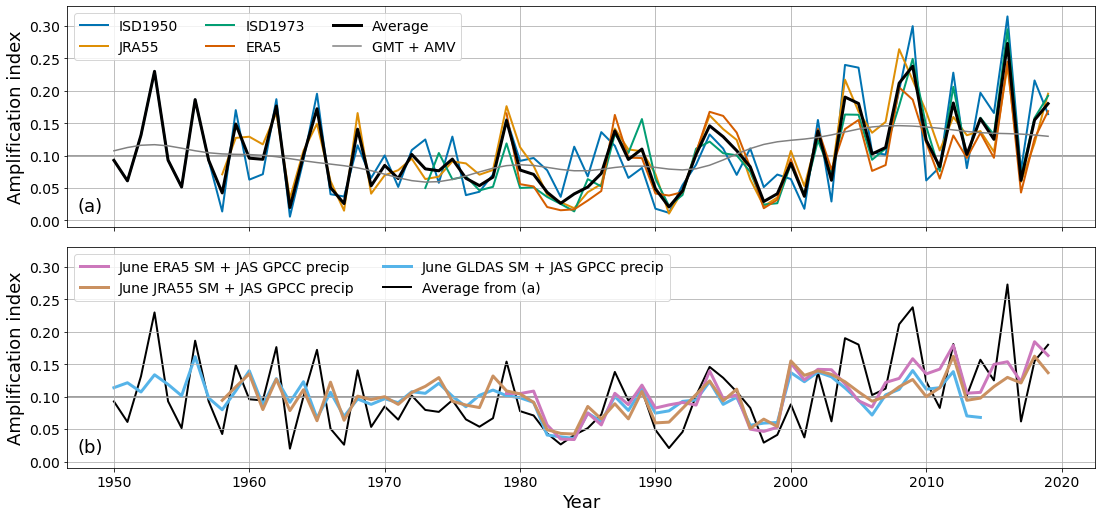

In [27]:
cb_palette = sns.color_palette('colorblind')

fig, ax = plt.subplots(figsize=(15, 7), nrows=2, sharex=True, sharey=True)
fig.tight_layout()

amplification_ISD1950.plot.line(y='ISD1950', ax=ax[0], lw=2, color=cb_palette[0])
amplification_JRA55.plot.line(y='JRA55', ax=ax[0], lw=2, color=cb_palette[1])
amplification_ISD1973.plot.line(y='ISD1973', ax=ax[0], lw=2, color=cb_palette[2])
amplification_ERA5.plot.line(y='ERA5', ax=ax[0], lw=2, color=cb_palette[3])
amplification_avg.plot.line(ax=ax[0], color='k', label='Average', lw=3)
amplification_fit.plot(ax=ax[0], color='gray')

# previously: darkmagenta, deepskyblue, palevioletred
amplification_fit2.plot(ax=ax[1], color=cb_palette[4], zorder=2, lw=3)
amplification_fit3.plot(ax=ax[1], color=cb_palette[5], zorder=2, lw=3)
amplification_fit4.plot(ax=ax[1], color=cb_palette[9], zorder=1, lw=3)

amplification_avg.plot.line(ax=ax[1], color='k', label='Average from (a)', zorder=0, lw=2)

ax[0].text(0.01, 0.07, '(a)', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.01, 0.07, '(b)', transform=ax[1].transAxes, fontsize=18)

ax[-1].set_xlabel('Year', fontsize=18)

for a in ax:
    a.tick_params(labelsize=14)
    a.grid()
    a.axhline(0.1, color='gray', zorder=0)
    
    a.set_ylabel('Amplification index', fontsize=18)
    
ax[0].legend(loc='upper left', fontsize=14, ncol=3)
ax[1].legend(loc='upper left', fontsize=14, ncol=2)
    
plt.savefig('%s/fig03.pdf' % figdir, dpi=200, bbox_inches='tight')

In [28]:
print('Average - ERA5 SM: %0.2f'
      % amplification_fit2.corrwith(amplification_avg)[0])

print('Average - JRA55 SM: %0.2f'
      % amplification_fit3.corrwith(amplification_avg)[0])

print('Average - GLDAS SM: %0.2f'
      % amplification_fit4.corrwith(amplification_avg)[0])

Average - ERA5 SM: 0.64
Average - JRA55 SM: 0.51
Average - GLDAS SM: 0.50


## Figure 4: Increased probability on hot, dry days linked to reduced surface evapotranspiration and soil moisture.

Panels are created here, but must be combined as a post-processing step.

In [29]:
# First four for main paper, last five for supplement
varnames = ('precip', 'e', 'swvl1-3', 'swvl1', 'ro', 'vimd', 'vimd', 'vimd', 'vimd')
longnames = ('JAS precipitation', 'JAS evapotranspiration', 
             'June 1m soil moisture', 'JAS surface soil moisture', 
             'JAS runoff', 'JAS VIMD', 'July VIMD', 'August VIMD', 'September VIMD')

for var_ct, this_varname in enumerate(varnames):

    print(this_varname)
    
    if this_varname == 'e':
        letter1 = '(a)'
        letter2 = '(b)'
    elif this_varname == 'swvl1':
        letter1 = '(c)'
        letter2 = '(d)'
    elif this_varname == 'swvl1-3':
        letter1 = '(e)'
        letter2 = '(f)'
    elif this_varname == 'precip':
        letter1 = '(g)'
        letter2 = '(h)'
    else:
        letter1 = ''
        letter2 = ''

    month_start = 7
    month_end = 9
    
    if 'June' in longnames[var_ct]:
        month_start = 6
        month_end = 6
    elif 'July' in longnames[var_ct]:
        month_start = 7
        month_end = 7
    elif 'August' in longnames[var_ct]:
        month_start = 8
        month_end = 8
    elif 'September' in longnames[var_ct]:
        month_start = 9
        month_end = 9
        
    if this_varname == 'swvl1-3':
        # sum up first three layers
        da_list = []
        for ct in range(1, 4):
            soil_var = 'swvl%i' % ct
            ds5 = xr.open_dataset('%s/%s/era5_%s.nc' % (era5_dir, soil_var, soil_var))
            ds5 = ds5.sel(expver=1)  # drop near RT
            ds5 = ds5.drop('expver')

            da = ds5[soil_var]
            del ds5
            
            da_list.append(da)

        da = 7/100*da_list[0] + 21/100*da_list[1] + 72/100*da_list[2]  # m3/m3 x meters (depth) = m3/m2 -> m
        units = 'm'
        
    elif this_varname == 'precip':
        da = xr.load_dataarray(gpcc_fname)
        units = da.attrs['units']
        da = da.rename({'lat': 'latitude',
                        'lon': 'longitude'})
        da = da.sel(time=(da['time.year'] >= 1979)) 
    else:
        ds5 = xr.open_dataset('%s/%s/era5_%s.nc' % (era5_dir, this_varname, this_varname))
        ds5 = ds5.sel(expver=1)  # drop near RT
        ds5 = ds5.drop('expver')

        da = ds5[this_varname]
        units = da.attrs['units']
        del ds5

    if this_varname == 'e':
        da *= -1  # change convention to have increase in evap mean increase in atm q

    if this_varname == 'swvl1':
        da *= 7/100  # m3/m3 x meters (depth) = m3/m2 -> m

    # Subset to the US (approx)
    da = da.sel(latitude=slice(55, 20), longitude=slice(230, 300))

    # don't need to remove seasonal cycle because we're differencing two periods with the same months
    da_anom = da.copy()
    da_anom = da_anom.sortby('latitude')
    da_anom = da_anom.sel(time=sel_season(da_anom['time.month'], month_start, month_end))
    da_anom = da_anom.groupby('time.year').mean()

    da_anom = da_anom.sel(year=(da_anom['year'] <= 2019))

    if ((this_varname == 'e') | (this_varname == 'vimd')):  # predict amplification
        era_ts = amplification_all.copy(deep=True)
        era_ts = era_ts['ERA5']
        era_ts = era_ts[~np.isnan(era_ts)]
        ylabel = 'ERA5 amplification'
    elif (this_varname == 'swvl1'):  # predict evaporation
        era_ts = pd.read_csv('%s/e_ts_month_7-9.csv' % fdir)
        era_ts = 1000*((era_ts.set_index('year'))['e'])
        ylabel = 'JAS evapotranspiration (mm)'
    else:  # prediction JAS soil moisture
        era_ts = pd.read_csv('%s/swvl1_ts_month_7-9.csv' % fdir)
        era_ts = 1000*(era_ts.set_index('year'))['swvl1']  #mm 
        ylabel = 'JAS surface soil moisture (mm)'

    top_idx = era_ts > np.percentile(era_ts, 100 - percentile_cutoff)
    bottom_idx = era_ts < np.percentile(era_ts, percentile_cutoff)

    top_years = era_ts.index.values[top_idx.values.flatten()]
    bottom_years = era_ts.index.values[bottom_idx.values.flatten()]

    da_top = da_anom.sel(year=np.isin(da_anom['year'], top_years)).mean('year')
    da_bottom = da_anom.sel(year=np.isin(da_anom['year'], bottom_years)).mean('year')

    if ((this_varname == 'e') | (this_varname == 'vimd')): 
        da_delta = da_top - da_bottom
    else:
        da_delta = da_bottom - da_top

    del da_top, da_bottom

    # Calculate time series
    da_anom = da_anom.assign_coords(longitude=(((da_anom.longitude + 180) % 360) - 180))
    nlon = len(da_anom.longitude)
    area_weights = np.cos(np.deg2rad(da_anom.latitude)).values
    area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
    da_anom = da_anom.to_dataset(name=this_varname)
    da_anom = da_anom.assign({'weights' : (('latitude', 'longitude'), area_weights)})
    da_anom = subset_to_west(da_anom, lon_range, lat_range, interior_west_shapely)
    ts = ((da_anom[this_varname]*da_anom.weights).sum(['latitude', 'longitude'])/
          da_anom.weights.sum(['latitude', 'longitude']))
    
    ts.to_dataframe(name=this_varname).to_csv('%s/%s_ts_month_%i-%i.csv' % (fdir, this_varname, 
                                                                            month_start, month_end))

    
    fig = plt.figure(figsize=(17, 15))
    widths = [10, 0.4]
    heights = [2.5, 1]
    spec = fig.add_gridspec(ncols=2, nrows=2, 
                            width_ratios=widths, height_ratios=heights)

    spec.update(wspace=0.1, hspace=0.1)

    # Set Projection of Data
    datacrs = ccrs.PlateCarree()

    # Set Projection of Plot
    plotcrs = ccrs.AlbersEqualArea(central_lon, central_lat)

    # Add the map and set the extent
    ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
    ax_map.set_extent(extent)

    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')

    ax_map.add_feature(cfeature.OCEAN, color='white', zorder=1)
    ax_map.add_feature(cfeature.LAKES, color='lightgray', zorder=1)
    ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=1)
    ax_map.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=1)
    ax_map.add_feature(states_provinces, edgecolor='gray', zorder=1)
    ax_map.add_geometries(interior_west['geometry'], crs=ccrs.PlateCarree(), 
                          facecolor='none', edgecolor='black', linewidth=2)

    if this_varname == 'vimd':
        cmap = plt.cm.BrBG_r
        levels = np.arange(-1, 1.1, 0.2)
        units = 'mm'
    elif this_varname == 'e':
        da_delta *= 1000 # change to mm
        ts *= 1000
        units = 'mm' #units.replace('m', 'mm')
        cmap = plt.cm.BrBG
        levels = np.arange(-0.5, 0.6, 0.1)
    elif 'swvl' in this_varname:
        da_delta *= 1000 # change to mm
        ts *= 1000
        units = 'mm'
        cmap = plt.cm.BrBG
        levels = np.arange(-40, 50, 10)
        if this_varname == 'swvl1':
            levels = np.arange(-4, 5, 1)
    elif this_varname == 'ro':
        cmap = plt.cm.BrBG_r
        levels = np.arange(-0.5, 0.51, 0.1)
        da_delta *= 1000 # change to mm
        ts *= 1000
        units = 'mm' 
    elif this_varname == 'precip':
        days_in_months = np.mean(np.array([calendar.monthrange(2020, mo)[-1] for 
                                  mo in np.arange(month_start, month_end + 1)]))
        da_delta /= days_in_months
        ts /= days_in_months
        cmap = plt.cm.BrBG
        
        levels = np.arange(-0.5, 0.51, 0.1)
        
    im = da_delta.plot.pcolormesh(ax=ax_map,
                                  transform=ccrs.PlateCarree(),
                                  levels=levels,
                                  cmap=cmap,
                                  add_colorbar=False,
                                  zorder=0)


    ax_map.text(0.01, 0.04, letter1, transform=ax_map.transAxes, fontsize=20)
    
    cax = fig.add_subplot(spec[0, 1])
    cb = plt.colorbar(im, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=14) 
    cb.set_label(r'$\Delta$%s (%s)' % (longnames[var_ct], units), fontsize=20)

    ax_ts = fig.add_subplot(spec[1, :])

    ax_ts.plot(ts.year, ts.values, '-s', color='teal', label=this_varname)

    if (this_varname == 'e'):
        ax_ts.invert_yaxis()
        ax_ts.set_ylim(1.8, 0.9)
        
    ax_ts.spines['left'].set_color('teal')
    ax_ts.tick_params(axis='y', colors='teal')
    ax_ts.set_ylabel('%s (%s)' % (longnames[var_ct], units), fontsize=20)
    ax_ts.yaxis.label.set_color('teal') 
    ax_ts.tick_params(labelsize=14)
    
    ax2 = ax_ts.twinx()
    ax2.plot(era_ts, '-s', color='darkorange')
    ax2.spines['right'].set_color('darkorange')
    ax2.tick_params(axis='y', colors='darkorange')
    ax2.set_ylabel(ylabel, fontsize=20)
    ax2.yaxis.label.set_color('darkorange')
    ax2.tick_params(labelsize=14)
    
    ax_ts.text(0.01, 0.07, letter2, transform=ax_ts.transAxes, fontsize=20)

    # Calculate significance and correlations for trended and detrended
    # Get degrees of freedom from residuals
    
    # Non-detrended model
    x1 = ts.values
    x1 = (x1 - np.mean(x1))/np.std(x1)
    X = sm.add_constant(x1) 
    y = era_ts.values
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    rho, _ = pearsonr(x1, y)
    df = ((1 - phi**2)/(1 + phi**2))*len(y)
    df -= 2  # mean and variance accounted for
    t_stat = np.sqrt(df*rho**2/(1 - rho**2))
    p_val = t.sf(t_stat, df)  
    
    # Detrended model
    x1 = ts.values
    x1 = (x1 - np.mean(x1))/np.std(x1)
    time_trend = np.arange(len(x1)).astype(float)
    time_trend -= np.mean(time_trend)
    X = sm.add_constant(np.vstack((x1, time_trend)).T) 
    y = era_ts.values
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    # print('Detrended AR(1) coeff of residuals: %0.2f' % phi)
    rho_detrended, _ = pearsonr(detrend(x1), detrend(y))
    df = ((1 - phi**2)/(1 + phi**2))*len(y)
    df -= 3  # mean and variance and trend accounted for
    t_stat = np.sqrt(df*rho_detrended**2/(1 - rho_detrended**2))
    p_val_detrended = t.sf(t_stat, df)  

    title_str = ('Pearson\'s r %0.2f, pval: %0.3f (%0.2f, pval: %0.3f)' % 
                    (rho, p_val,
                     rho_detrended, p_val_detrended))

    title_str = title_str.replace(': 0.000', ' < 0.001')

    ax_ts.set_title(title_str, fontsize=20)
    del da_delta

    plt.savefig('%s/fig04_%s_%s.pdf' % 
                (figdir, longnames[var_ct].split(' ')[0], this_varname), bbox_inches='tight')
    
    plt.close()

precip


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


e


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


swvl1-3


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


swvl1


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


ro


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


vimd


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


vimd


/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


vimd
vimd


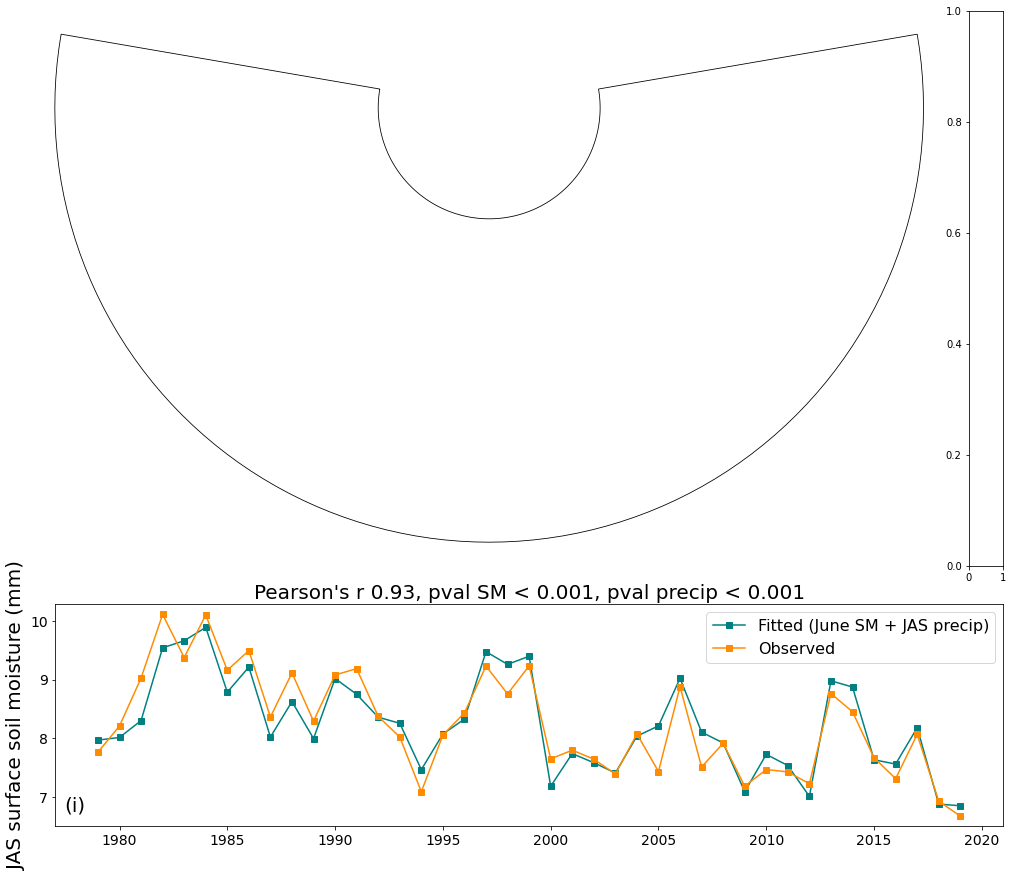

In [30]:
# Create bottom panel -- time series only

# Predict JAS soil moisture with both precip and soil moisture
swvl_june_ts = pd.read_csv('%s/swvl1-3_ts_month_6-6.csv' % fdir)
pr_ts = pd.read_csv('%s/precip_ts_month_7-9.csv' % fdir)
swvl1_ts = pd.read_csv('%s/swvl1_ts_month_7-9.csv' % fdir)

# Predict JAS SM with June SM, JAS precip
x1 = swvl_june_ts['swvl1-3'].values
x2 = pr_ts['precip'].values

# normalize both for comparison
x1 = (x1 - np.mean(x1))/np.std(x1)
x2 = (x2 - np.mean(x2))/np.std(x2)

X = np.vstack((x1, x2)).T
X = sm.add_constant(X) 
y = 1000*swvl1_ts['swvl1'].values   # mm
 
model = sm.OLS(y, X).fit()

ts = xr.DataArray(model.predict(X), dims=['year'], coords=[swvl_june_ts.year.values])
era_ts = pd.read_csv('%s/swvl1_ts_month_7-9.csv' % fdir)
era_ts = 1000*(era_ts.set_index('year'))['swvl1']  #mm 

rho = np.sqrt(model.rsquared)

# Update calculation of p-values with estimated dof
residuals = model.resid
phi = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
df = ((1 - phi**2)/(1 + phi**2))*model.df_resid

# one sided, since we know low SM -> high amp, low precip -> high amp
pvals = t.sf(np.abs(model.tvalues), df)  

# Plot time series only, but same shape as other ones with maps
fig = plt.figure(figsize=(17, 15))
widths = [10, 0.4]
heights = [2.5, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, 
                        width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.1)

ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
ax_cb = fig.add_subplot(spec[0, 1])

ax_ts = fig.add_subplot(spec[1, :])

ax_ts.plot(ts.year, ts.values, '-s', color='teal', label='Fitted (June SM + JAS precip)')

if (this_varname == 'e'):
    ax_ts.invert_yaxis()
    ax_ts.set_ylim(1.9, 0.8)

ax_ts.set_ylabel('JAS surface soil moisture (mm)', fontsize=20)
ax_ts.tick_params(labelsize=14)
ax_ts.plot(era_ts, '-s', color='darkorange', label='Observed')
ax_ts.legend(fontsize=16)

title_str = ('Pearson\'s r %0.2f, pval SM: %0.3f, pval precip: %0.3f' % (rho, pvals[0], pvals[1]))

title_str = title_str.replace(': 0.000', ' < 0.001')

ax_ts.set_title(title_str, fontsize=20)
ax_ts.text(0.01, 0.07, '(i)', transform=ax_ts.transAxes, fontsize=20)
plt.savefig('%s/fig04_bottom.pdf' % figdir, bbox_inches='tight')

## Figure 5: CMIP6 projections of pre-summer column soil moisture, summer precipitation, and summer surface soil moisture.

In [31]:
def preprocess_monthly_netcdf_cmip6(fnames, this_var, month1, month2):
    
    """Get time series of seasonal averages of a given variable in the Southwest."""
    
    # Load files
    ds = xr.open_mfdataset(fnames, combine='nested', concat_dim='time')
    da = ds[this_var]

    # Subset to month range
    da = da.sel(time=((da['time.month'] >= month1) & (da['time.month'] <= month2)))
    
    # take annual average
    da = da.groupby('time.year').mean()
    
    # change longitude
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180))
    da = da.sortby('lon')

    # Subset to west (approx)
    da = da.sel(lat=slice(lat_range[0], lat_range[1]),
                lon=slice(lon_range[0], lon_range[1]))
    
    da = da.sel(year=slice('1850', '2100'))

    # Create time series, area-weighted
    nlon = len(da.lon)
    area_weights = np.cos(np.deg2rad(da.lat)).values
    area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
    da = da.to_dataset(name=this_var)
    da = da.assign({'weights' : (('lat', 'lon'), area_weights)})
    da = da.salem.roi(geometry=interior_west_shapely, crs='wgs84')

    ts = ((da[this_var]*da.weights).sum(['lat', 'lon'])/
          da.weights.sum(['lat', 'lon']))
    
    return ts

In [32]:
# Calculate time series from CMIP6 models

# June soil moisture, historical and future
month1 = 6
month2 = 6
exp_name = 'hist_plus_ssp'
var_name = 'mrso'

savename = '%s/%s_%i-%i_%s.nc' % (fdir, var_name, month1, month2, exp_name)
if not os.path.isfile(savename):

    modelnames = sorted(glob('%s/historical/%s/*' % (cmip6_dir, var_name)))
    modelnames = [m.split('/')[-1] for m in modelnames]
    if 'MCM-UA-1-0' in modelnames:  # issues with model output
        modelnames.remove('MCM-UA-1-0')

    da_list = []
    N = np.nan*np.ones(len(modelnames))

    for ct, this_model in enumerate(modelnames):
        print(this_model)

        # Historical files
        these_files = sorted(glob('%s/historical/%s/%s/*/*/*.nc' % (cmip6_dir, var_name, this_model)))

        # Get files for each ensemble member
        em_member_names = sorted(np.unique([f.split('/')[8] for f in these_files]))
        ts_single_model = []
        n = 0
        for em_member_use in em_member_names:

            # get historical and ssp
            these_files = sorted(glob('%s/*/%s/%s/%s/*/*.nc' % (cmip6_dir, var_name, this_model, em_member_use)))

            # check that both historical and ssp are present
            has_both = (np.array(['historical' in f for f in these_files]).any() & 
                        np.array(['ssp' in f for f in these_files]).any())
            if has_both:
                n += 1
                if len(these_files) > 1:
                    start_year = np.array([int(f.split('/')[-1].split('_')[-1].split('.')[0].split('-')[0]) 
                                           for f in these_files])
                    too_late = start_year > 210100
                    if too_late.any():
                        these_files = these_files[:np.where(too_late)[0][0]]

            ts = preprocess_monthly_netcdf_cmip6(these_files, var_name, month1, month2)
            ts_single_model.append(ts)
            N[ct] = n
            del ts

        ts = xr.concat(ts_single_model, dim='member')
        ts = ts.mean('member')  # get EM of each model

        da_list.append(ts)

    da = xr.concat(da_list, dim='model', coords='minimal', compat='override')
    da = da.assign_coords(model=modelnames)

    da.to_netcdf(savename)
    np.save('%s/%s_%i-%i_%s_N.npy' % (fdir, var_name, month1, month2, exp_name), N)

    
# Future only: June soil moisture, JAS precip, JAS soil moisture (surface)
varnames = 'mrsos', 'mrso', 'pr'
exp_name = 'ssp585'
this_cmip6_dir = '%s/%s' % (cmip6_dir, exp_name)
for var_name in varnames:
    if var_name == 'mrso': 
        month1 = 6
        month2 = 6
    else:
        month1 = 7
        month2 = 9
        
    savename = '%s/%s_%i-%i_%s.nc' % (fdir, var_name, month1, month2, exp_name)
    if not os.path.isfile(savename):

        modelnames = sorted(glob('%s/%s/*' % (this_cmip6_dir, var_name)))
        modelnames = [m.split('/')[-1] for m in modelnames]
        if 'MCM-UA-1-0' in modelnames:
            modelnames.remove('MCM-UA-1-0')

        da_list = []
        N = np.nan*np.ones(len(modelnames))

        for ct, this_model in enumerate(modelnames):
            print(this_model)

            these_files = sorted(glob('%s/%s/%s/*/*/*.nc' % (this_cmip6_dir, var_name, this_model)))

            # Get files for each ensemble member
            em_member_names = sorted(np.unique([f.split('/')[8] for f in these_files]))
            ts_single_model = []
            for em_member_use in em_member_names:

                these_files = sorted(glob('%s/%s/%s/%s/*/*.nc' % (this_cmip6_dir, var_name, 
                                                                  this_model, em_member_use)))


                if 'ssp' in exp_name:
                    if len(these_files) > 1:
                        start_year = np.array([int(f.split('/')[-1].split('_')[-1].split('.')[0].split('-')[0]) 
                                               for f in these_files])
                        too_late = start_year > 210100
                        if too_late.any():
                            these_files = these_files[:np.where(too_late)[0][0]]
                N[ct] = len(these_files)
                ts = preprocess_monthly_netcdf_cmip6(these_files, var_name, month1, month2)
                ts_single_model.append(ts)
                del ts

            ts = xr.concat(ts_single_model, dim='member')
            ts = ts.mean('member')  # get EM of each model

            da_list.append(ts)

        da = xr.concat(da_list, dim='model', coords='minimal', compat='override')
        da = da.assign_coords(model=modelnames)

        da.to_netcdf('%s/%s_%i-%i_%s.nc' % (fdir, var_name, month1, month2, exp_name))
        np.save('%s/%s_%i-%i_%s_N.npy' % (fdir, var_name, month1, month2, exp_name), N)

/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/ipykernel_laun

Frac of models with neg Jun SM trend: 0.815
Frac of models with sig. neg Jun SM trend: 0.667
Frac of models with pos JAS pr trend: 0.704
Frac of models with sig. pos JAS pr trend: 0.481
Frac of models with pos and sig JAS sm trend: 0.185
Frac of models with neg and sig JAS sm trend: 0.296
Frac of models with insig JAS sm trend: 0.519


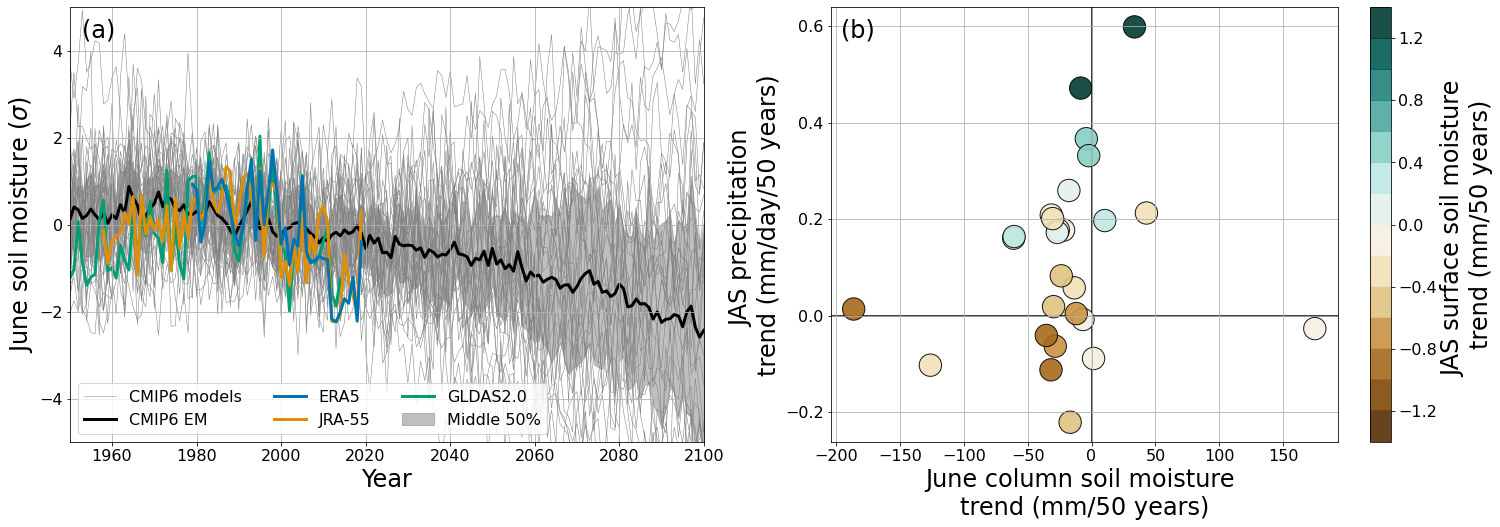

In [33]:
# Load CMIP6 values
da_sm_cmip6 = xr.open_dataarray('%s/mrso_6-6_hist_plus_ssp.nc' % fdir)

# normalize over period shared with obs
da_sm_cmip6_anom = da_sm_cmip6 - (da_sm_cmip6.sel(year=slice(1979, 2014))).mean('year')
da_sm_cmip6_norm = da_sm_cmip6_anom/((da_sm_cmip6_anom.sel(year=slice(1979, 2014))).std('year'))

q1 = 0.25
q2 = 0.75
da_sm_cmip6_perc = da_sm_cmip6_norm.quantile(q=(q1, q2), dim='model')

ts_SM_ERA5_norm = ((ts_SM_ERA5 - (ts_SM_ERA5.sel(year=slice(1979, 2014))).mean())/
                   (ts_SM_ERA5.sel(year=slice(1979, 2014))).std())
ts_SM_JRA55_norm = ((ts_SM_JRA55 - (ts_SM_JRA55.sel(year=slice(1979, 2014))).mean())/
                   (ts_SM_JRA55.sel(year=slice(1979, 2014))).std())
ts_SM_GLDAS_norm = ((ts_SM_GLDAS - (ts_SM_GLDAS.sel(year=slice(1979, 2014))).mean())/
                   (ts_SM_GLDAS.sel(year=slice(1979, 2014))).std())

fig, ax = plt.subplots(figsize=(25, 8), ncols=2)

# normalize all soil moisture for plotting over shared period
da_sm_cmip6_norm[0, :].plot.line(x='year', color='gray', lw=0.5, ax=ax[0], 
                               add_legend=False, label='CMIP6 models', zorder=0)
da_sm_cmip6_norm.plot.line(x='year', color='gray', lw=0.5, ax=ax[0], add_legend=False, zorder=0)

(da_sm_cmip6_norm.mean('model')).plot.line(x='year', color='k', lw=3, ax=ax[0], label='CMIP6 EM', zorder=0)
ax[0].fill_between(da_sm_cmip6_perc.year, da_sm_cmip6_perc.sel(quantile=q1), da_sm_cmip6_perc.sel(quantile=q2),
                color='gray', alpha=0.5, label='Middle 50%', zorder=0)

ts_SM_ERA5_norm.plot.line(ax=ax[0], label='ERA5', color=cb_palette[0], lw=3, zorder=3)
ts_SM_JRA55_norm.plot.line(ax=ax[0], label='JRA-55', color=cb_palette[1], lw=3, zorder=2)
ts_SM_GLDAS_norm.plot.line(ax=ax[0], label='GLDAS2.0', color=cb_palette[2], lw=3, zorder=1)
ax[0].set_ylim(-5, 5)
ax[0].set_xlim(1950, 2100)
ax[0].grid()


da_JAS_sm = xr.open_dataarray('%s/mrsos_7-9_ssp585.nc' % fdir)
da_June_sm = xr.open_dataarray('%s/mrso_6-6_ssp585.nc' % fdir)
da_JAS_pr = xr.open_dataarray('%s/pr_7-9_ssp585.nc' % fdir)

# precipitation is /sec
da_JAS_pr *= 24*60*60

trend_length = 50  # plot trends over this many years

shared_models = np.intersect1d(da_JAS_pr.model.values, 
                               np.intersect1d(da_JAS_sm.model.values, da_June_sm.model.values))

# Calculate linear trend in each model and each variable
years = da_JAS_pr.year.values.astype(float)
years -= np.mean(years)

beta_JAS_sm = np.nan*np.ones((len(shared_models), ))
beta_June_sm = np.nan*np.ones((len(shared_models), ))
beta_JAS_pr = np.nan*np.ones((len(shared_models), ))

pval_JAS_sm = np.nan*np.ones((len(shared_models), ))
pval_June_sm = np.nan*np.ones((len(shared_models), ))
pval_JAS_pr = np.nan*np.ones((len(shared_models), ))

# Calculate slopes and p-values
for m, this_model in enumerate(shared_models):

    # JAS soil moisture
    X = da_JAS_sm.year.astype(float)
    X -= np.mean(X)
    X = sm.add_constant(X)
    model = sm.OLS(da_JAS_sm.sel(model=this_model).values, X).fit()
    beta_JAS_sm[m] = model.params[-1]
    pval_JAS_sm[m] = model.pvalues[-1]
    
    # June soil moisture
    X = da_June_sm.year.astype(float)
    X -= np.mean(X)
    X = sm.add_constant(X)
    model = sm.OLS(da_June_sm.sel(model=this_model).values, X).fit()
    beta_June_sm[m] = model.params[-1]
    pval_June_sm[m] = model.pvalues[-1]
    
    # JAS precip
    X = da_JAS_pr.year.astype(float)
    X -= np.mean(X)
    X = sm.add_constant(X)
    model = sm.OLS(da_JAS_pr.sel(model=this_model).values, X).fit()
    beta_JAS_pr[m] = model.params[-1]
    pval_JAS_pr[m] = model.pvalues[-1]
    

print('Frac of models with neg Jun SM trend: %0.3f' % 
      (np.sum(beta_June_sm < 0)/np.sum(~np.isnan(beta_June_sm))))
print('Frac of models with sig. neg Jun SM trend: %0.3f' % 
      (np.sum((beta_June_sm < 0) & (pval_June_sm < 0.01))/np.sum(~np.isnan(beta_June_sm))))

print('Frac of models with pos JAS pr trend: %0.3f' % 
      (np.sum(beta_JAS_pr > 0)/np.sum(~np.isnan(beta_JAS_pr))))
print('Frac of models with sig. pos JAS pr trend: %0.3f' % 
      (np.sum((beta_JAS_pr > 0) & (pval_JAS_pr < 0.01))/np.sum(~np.isnan(beta_JAS_pr))))

print('Frac of models with pos and sig JAS sm trend: %0.3f' % 
      (np.sum((beta_JAS_sm > 0) & (pval_JAS_sm < 0.01))/np.sum(~np.isnan(beta_JAS_sm))))
print('Frac of models with neg and sig JAS sm trend: %0.3f' % 
      (np.sum((beta_JAS_sm < 0) & (pval_JAS_sm < 0.01))/np.sum(~np.isnan(beta_JAS_sm))))
print('Frac of models with insig JAS sm trend: %0.3f' % 
      (np.sum((pval_JAS_sm > 0.01))/np.sum(~np.isnan(beta_JAS_sm))))


cmap = plt.cm.BrBG
bounds = np.arange(-1.4, 1.5, 0.2)
norm = colors.BoundaryNorm(bounds, cmap.N)

sc = ax[1].scatter(trend_length*beta_June_sm, 
                trend_length*beta_JAS_pr, 
                500,
                trend_length*beta_JAS_sm,
                cmap=cmap,
                norm=norm,
                alpha=0.9,
                marker='o',
                edgecolor='k')

ax[1].grid()
ax[1].axvline(0, color='k', zorder=0)
ax[1].axhline(0, color='k', zorder=0)
cb = plt.colorbar(sc)

ax[0].set_xlabel('Year', fontsize=24)
ax[0].set_ylabel(r'June soil moisture ($\sigma$)', fontsize=24)

ax[1].set_xlabel('June column soil moisture \ntrend (mm/%i years)' % trend_length, fontsize=24)
ax[1].set_ylabel('JAS precipitation \ntrend (mm/day/%i years)' % trend_length, fontsize=24)
cb.set_label('JAS surface soil moisture \ntrend (mm/%i years)' % trend_length, fontsize=24)
for a in ax:
    a.tick_params(labelsize=16)
cb.ax.tick_params(labelsize=16) 
ax[0].legend(loc='lower left', fontsize=16, ncol=3)

ax[0].text(0.02, 0.93, '(a)', transform=ax[0].transAxes, fontsize=24)
ax[1].text(0.02, 0.93, '(b)', transform=ax[1].transAxes, fontsize=24)

plt.savefig('%s/fig05.pdf' % figdir, bbox_inches='tight')